2.12.0
Found 10000 files belonging to 2 classes.
Using 7500 files for training.
Using 2500 files for validation.

Model Summary:
    Model name: /kaggle/working/saved_model/ResNet50V2_model_cats_dogs_10k
    Load Model: True
    Save Model: True
    Training: True
    Predictions: True
    Dataset: /kaggle/working/cats-and-dogs/
    Architecture: ResNet50V2
    Img Dimension: 224,224
    Autotune: True
    32 images in each batch. 235 batches needed to run full dataset
    Classes to infer: ['cats', 'dogs']




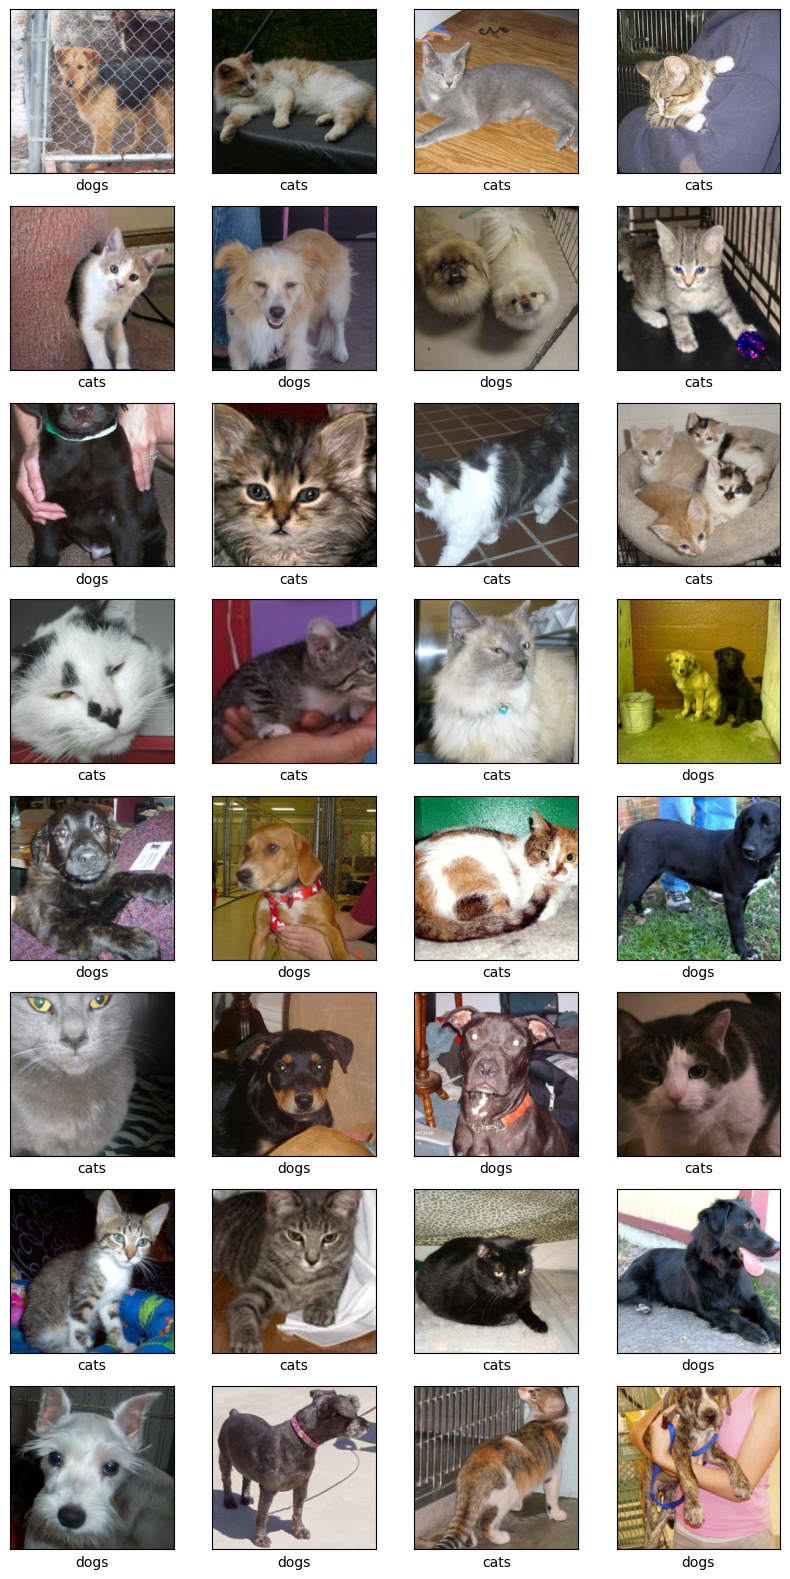

In [13]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import pathlib
import time, datetime
import gc

from tensorflow import keras
from tensorflow import data
from tensorflow.keras import utils

print(tf.__version__)

# batch_size is how many samples in the batch
batch_size = 32 # Seems like the standard
if batch_size%4:
    print("THIS CODE AIN'T GONNA RUN, BABY")

batch_size = 32
augmentation = True

running_tensorflow = False # Don't run it in Kaggle environment because Kaggle have disabled it for few years now
if running_tensorflow:
    # Clear any logs from previous runs, so we can put new ones in
    !rm -rf ./logs/ # TEMP not sure if this works, is illegal, etc
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Use model to predict and / or fit=train. You decide
training_time = True # do we want to train this time
training_epochs = 20
prediction_time = True
patience = 5 # how patient are we waiting for the model to start working
learning_rate = 0.01 # Very important hyperparam. Don't start too big

save_model = True # Do we want to save the model this iteration (has user confirm on, not auto)
load_model = True # Read model from disk if it exists rather than create new one
 
# Decide on dataset to use
#dataset_path = '/kaggle/input/leeds-shirts/'
# This is old one I made myself locally - only 1000 images total
#dataset_path = '/kaggle/input/cats-and-dogs/'
# Get 70% with EfficientNetV2B0

# This is the current one we are training. The 10K one.
dataset_path = '/kaggle/working/cats-and-dogs/'

display_training_images = True

#architecture = 'my_custom_architecture'
#architecture = 'Xception'
architecture = 'ResNet50V2'
#architecture= 'EfficientNetV2B0'

autotune = True # No reason to turn this off. Three times quicker when on. Nothing to do with model type, right?

# Are we fine tuning this round?
# TEMP if this is true do we still do training/predictions?
# This code only valid if we are using pretrained_weights. This code is not up to date
pretrained_weights = False
fine_tuning = False
fine_tuning_epochs = 10
if pretrained_weights == False:
    fine_tuning = False

def construct_model_name(base_name,end_name):
    # Should this be lambda function or something. Only one line
    return '/kaggle/working/saved_model/' + base_name + end_name

# Model name is per dataset+architecture, not just architecture
# cats_and_dogs is default model name
if architecture == 'Xception':
    img_height, img_width=299,299
    #model_name = 'saved_model/xception_model' # TEMP expand this code if we go back to Xception
    model_name = construct_model_name(architecture,'_dataset_undefined')
elif architecture == 'EfficientNetV2B0':
    img_height, img_width=224,224
    if dataset_path == '/kaggle/input/cats-and-dogs/': # Input is the tiny one I did
        model_name = construct_model_name(architecture,'_model_cats_dogs_1k')
    elif dataset_path == '/kaggle/working/cats-and-dogs/': # The one I tweak the size of to try and get resnet running
        model_name = construct_model_name(architecture,'_model_cats_dogs_10k')
    elif dataset_path == '/kaggle/input/leeds-shirts/':
        model_name = construct_model_name(architecture,'_model_leeds_shirts')
    else:
        print("We have a weird dataset_path")
elif architecture == 'ResNet50V2':
    img_height, img_width=224,224
    if dataset_path == '/kaggle/input/cats-and-dogs/': # Input is the tiny one I did
        model_name = construct_model_name(architecture,'_model_cats_dogs_1k')
    elif dataset_path == '/kaggle/working/cats-and-dogs/':
        model_name = construct_model_name(architecture,'_model_cats_dogs_10k')
    elif dataset_path == '/kaggle/input/leeds-shirts/':
        model_name = construct_model_name(architecture,'_model_leeds_shirts')
    else:
        print("We have a weird dataset_path")
elif architecture == 'my_custom_architecture':
    img_height, img_width=224,224
    model_name = construct_model_name(architecture,'_dataset_undefined')

def print_summary():
    print(f'\nModel Summary:')
    print(f'    Model name: {model_name}')
    print(f'    Load Model: {load_model}')
    print(f'    Save Model: {save_model}')
    print(f'    Training: {training_time}')
    print(f'    Predictions: {prediction_time}')
    print(f'    Dataset: {dataset_path}')
    print(f'    Architecture: {architecture}')
    print(f'    Img Dimension: {img_height},{img_width}')
    print(f'    Autotune: {autotune}')
    print(f'    {batch_size} images in each batch. {train_ds.cardinality().numpy()} batches needed to run full dataset')
    print(f'    Classes to infer: {train_ds.class_names}')
    print('\n')
    
# Generates a tf.data.Dataset from image files in a directory.
# It expects to find a class structure. So if you have two directories, it will create two classes
# New version doesn't transform images. We leave stuff up to the model. The model should do as much as possible.
# It should take raw images as far as possible
# Except the image_size is not optional here... so now we are doing it in two places sometimes, oops
train_ds, val_ds = utils.image_dataset_from_directory(
    dataset_path,
    labels = 'inferred',
    validation_split=0.25, # Should be 888-> 666 training files, = 222 validation files 
    #validation_split=0.50, # Should be 888-> 666 training files, = 222 validation files 
    subset="both", # Generates a tuple of training data and validation data
    seed=123,
    batch_size = batch_size,
    label_mode = 'binary', # This encodes labels as float32 scalars (i.e numpy objects) so I don't know how to convert them to int to print
    interpolation = 'bilinear', # This is standard across imagesets
    shuffle = True, # Shuffle if we want to try with new data each time else fixed order
    image_size=(img_height, img_width),
    crop_to_aspect_ratio = True,
)

print_summary()

# Print labels in sources images
#print(train_ds.class_names)

# Store these to use later TEMP terrible kludge, not sure why just can't access train_ds.class_names directly?????
class_array = train_ds.class_names
#print(class_array)
#print(type(class_array))

if display_training_images:
    plt.figure(figsize=(10, 20))
    for images, labels in train_ds.take(1):
      for i in range(batch_size): 
        plt.subplot(int(batch_size/4),4, i + 1) # TEMP this must equal batch_size or code falls apart completely. Not ood
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i].numpy().astype("uint8"))
        # labels[i] is float32 scalars with values 0 or 1 (e.g. for binary_crossentropy).
        # So need convert from numpy ndarray to float and then int...    
        plt.xlabel(train_ds.class_names[int(labels[i].numpy()[0])])

autotune = True # No reason to turn this off. Three times quicker when on. Nothing to do with model type, right?
# TEMP currently running prefetch with buffer size  = -1. What does that do? Maybe coz it's dynamic it will change
# but we are not in any loop so how will it get adjusted?
# All tuning stuff: https://www.tensorflow.org/guide/data_performance
# Currently using .cache() and .prefetch()
if autotune:
    AUTOTUNE = data.experimental.AUTOTUNE
    #print(f"Autotuning (much faster) with buffer size {AUTOTUNE}. Not sure why buffer size is neg.")
    train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [14]:
# create_model() definition
# returns: model
# Nothing to run in here, sorry
from tensorflow import keras
from tensorflow.keras import layers 

def create_model(architecture,augmentation=False):
    if architecture == 'my_custom_architecture' and pretrained_weights == False:
        if augmentation:
            data_augmentation = keras.Sequential([
                layers.RandomFlip("horizontal",input_shape=(img_height, img_width, 3)),
                layers.RandomRotation(0.2),
            ])
        resize_and_rescale = keras.Sequential([
            layers.CenterCrop(img_height,img_width), # Just like this better than resize
            #layers.Resizing(img_height, img_width), # TEMP Shouldn't need this as did as part of image load, but how to make sure
            layers.Rescaling(1./255)
        ])
        sigmoid_initializer = 'glorot_normal'
        relu_initializer = 'he_normal' # Never use glorot_normal in relu_initializer
        kernel_regularizer = None # Can change this to 'L2' or whatever if want to use it
        # I basically naively tried to emulate vgg16
        print("Doing the lee_custom_model_ dance (with no initial weights, it's a virgin net)")
        model = keras.Sequential()
        model.add(keras.Input(shape=(img_height, img_width, 3)))
        # Block One
        model.add(resize_and_rescale)
        if augmentation:
            model.add(data_augmentation)
            print("Augmenting the (training) model with flips and rotates mf")
        model.add(layers.Conv2D(filters=64,
                  kernel_size=3,
                  activation='relu',
                  padding='same',
                  kernel_regularizer = kernel_regularizer,
                  kernel_initializer = relu_initializer,
                  name = '1st_Conv2D_Layer',))
        model.add(layers.Dropout(0.1))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D(pool_size = (2, 2), strides = (2,2)))
        # Block Two
        model.add(layers.Conv2D(filters=128,
                          kernel_size=3,
                          activation='relu',
                          padding='same',
                          kernel_regularizer = kernel_regularizer,
                          kernel_initializer = relu_initializer,))
        model.add(layers.Dropout(0.2))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D(pool_size = (2, 2), strides = (2,2)))
        # Block Three
        model.add(layers.Conv2D(filters=256,kernel_size=3,activation='relu',padding='same',
                                kernel_regularizer = kernel_regularizer, kernel_initializer = relu_initializer,))
        model.add(layers.Dropout(0.1))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D(pool_size = (2, 2), strides = (2,2)))
        model.add(layers.Dropout(0.5))
        model.add(layers.BatchNormalization())
        # Block Four - now at 14
        model.add(layers.Conv2D(filters=512,kernel_size=3,activation='relu',padding='same',
                                kernel_regularizer = kernel_regularizer, kernel_initializer = relu_initializer,))
        model.add(layers.Dropout(0.2))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D(pool_size = (2, 2), strides = (2,2)))
         # Block Five - now at 7
        model.add(layers.Conv2D(filters=512,kernel_size=3,activation='relu',padding='same',
                                kernel_regularizer = kernel_regularizer,kernel_initializer = relu_initializer,))  
        model.add(layers.Dropout(0.1))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D(pool_size = (2, 2), strides = (2,2)))
        # Head - Always need to flatten because Keras requires a 1D array as input to dense layers
        model.add(layers.Flatten(name = 'flatten_before_dense'),)
        # 1st dense layer
        model.add(layers.Dense(units=4096,activation='relu',kernel_regularizer = kernel_regularizer,kernel_initializer = relu_initializer,
                         name = '1st_Dense_Layer',),)
        model.add(layers.Dropout(0.5),)
        model.add(layers.BatchNormalization())
        # Output layer
        model.add(layers.Dense(units = 1, # Single layer coz binary classification ✅
                         activation = 'sigmoid',
                         kernel_initializer = sigmoid_initializer,))
        return model
    
    if architecture == 'Xception' and pretrained_weights == False:
        # A virgin model (no weights) using the Xception architecture
        xception = keras.applications.Xception(weights=None,include_top=True,classes=1,classifier_activation='sigmoid')
        model = tf.keras.models.Sequential()
        # We add the 'input_shape' here to cause Keras to add an input for the model behind the scenes.
        # Add a preprocess layer specific to xception
        model.add(tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input, input_shape=(img_width,img_height,3)))
        model = augment_model(model,augmentation)
        model.add(xception)
        print("Finished creating Xception model shape but not instantiated it yet")
        return model
    
    if architecture == 'ResNet50V2' and pretrained_weights == False:
        # A virgin model (no weights) using the resnet50v2 architecture
         # For sigmoid, classes must be 1. For softmax, must be 2 if binary problem
        resnet50v2 = keras.applications.ResNet50V2(weights=None, include_top=True, classes=1,classifier_activation='sigmoid')
        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.Lambda(tf.keras.applications.resnet_v2.preprocess_input, input_shape=(img_width,img_height,3)))
        # Resnet does not scale in preprocess layer, so I have to
        model.add(tf.keras.layers.Rescaling(scale=1./255))
        model = augment_model(model,augmentation)
        model.add(resnet50v2)
        print("Finished creating Resnet50V2 model shape but not instantiated it yet")
        return model
    
    
    if architecture == 'EfficientNetV2B0' and pretrained_weights == False:
        # A virgin model (no weights) using the EfficientNetV2B0 architecture
         # For sigmoid, classes must be 1. For softmax, must be 2 if binary problem
        efficientnetv2b0 = keras.applications.EfficientNetV2B0(weights=None, include_top=True, classes=1,classifier_activation='sigmoid')
        model = tf.keras.models.Sequential()
        # No preprocessing needed for EfficientNet
        #model.add(tf.keras.layers.Lambda(tf.keras.applications.efficientnet.preprocess_input, input_shape=(img_width,img_height,3)))
        # EfficientNet does not scale in preprocess layer, so I have to
        # EfficientNetV2 does preprocessing, so don't need to scale
        #model.add(tf.keras.layers.Rescaling(scale=1./255))
        model = augment_model(model,augmentation)
        model.add(efficientnetv2b0)
        print("Finished creating EfficientNetV2B0 model shape but not instantiated it yet")
        return model
    
    # Should never get to here
    print("Don't have a model for this situation, sorry")

def augment_model(this_model,augmentation):
    if augmentation:
            print("Augmenting the model with random stuff")
            this_model.add(keras.layers.RandomRotation(0.2))
            this_model.add(keras.layers.RandomFlip("horizontal"))
    return this_model

In [15]:
# history_visualizer() definition.
# Returns: nothing
# Nothing to run in here, sorry

def visualizer_fitting_results(history, binary = True):
    # Input is a history object. The result of running fit()
    # Visualize the loss and accuracy over the last number of epochs
    print("Printing the training accuracy: " + str(history.history['binary_accuracy']))
    print("Printing the validation accuracy: " + str(history.history['val_binary_accuracy']))
    print("Printing the training loss: " + str(history.history['loss']))
    print("Printing the validation loss: " + str(history.history['val_loss']))
    
    if binary:
        acc = history.history['binary_accuracy']
        val_acc = history.history['val_binary_accuracy']
    else:
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc)) # Can't use range(epochs) coz earlystopping might prevent #epochs reaching 'epoohs'

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

# compile_the_model() definition.
# Nothing to run in here, sorry
from tensorflow import keras
 
def compile_the_model(model, learning_rate):
    # Must have the right code for all potential models we run
    # The code should actually be identical, regardless of model
    model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate = learning_rate,
                                                     epsilon = 0.1,
                                                    ),
                  metrics=['binary_accuracy'] )

In [16]:
# No code to run here, dude. Just definitions
from tensorflow.keras import callbacks

def use_model_to_fit(model,epochs,patience=5):
    early_stopping = callbacks.EarlyStopping(monitor='val_loss',
                                            patience = patience,
                                            min_delta = 0.00,
                                            restore_best_weights = True,
                                            verbose = 1,
                                            start_from_epoch = 10,)

    if running_tensorflow:
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
        callback = [early_stopping, tensorboard_callback,]
    else:
        callback = [early_stopping,]
    history = model.fit(train_ds, validation_data = val_ds, epochs=epochs, verbose = 1, callbacks = [callback])
    print("\nFinished fitting the model")
    visualizer_fitting_results(history,binary=True)
    print("\nFinished viewing the fitting results")

def use_model_to_evaluate(model, ds):
    # This should only be run on test data
    # We need to pass in the correct labels for this, though, as they are known
    # Where do we get them from?
    pass

In [11]:
# Model creation, compilation, and fitting (running) loop
from tensorflow.keras import utils

if load_model:
    print(f"Loading {model_name} from disk instead of creating a new model")
    model = tf.keras.models.load_model(model_name)
    model.summary()
else:
    print("Creating a model from scratch rather than loading one from disk")
    model = create_model(architecture,augmentation)
    compile_the_model(model,learning_rate=learning_rate)

Loading /kaggle/working/saved_model/ResNet50V2_model_cats_dogs_10k from disk instead of creating a new model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 224, 224, 3)      0         
 tion)                                                           
                                                                 
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 1)                 23566849  
                                                                 
Total params:

In [17]:
# Definition code only
def use_model_to_predict(model, ds):
    # predict() is used to predict whether an object is class 1 or 2
    # It can be run on validation data (in which case we know what it should be), or test data, when we have no idea
    # Currently just call it on validation data coz we don't have any test data available
    batches_to_display = 3
    # predict() returns a numpy array(s) of predictions. We can do predictions.size to get its size
    predictions = model.predict(ds,
                               verbose=2,
                               steps=batches_to_display, # For 2 step, this is batch_size*steps, makes sense
                               )
    print("\nFinished viewing the predictions")
    print("\nNow let's plot the predictions")
    if predictions.size != batch_size*batches_to_display:
        print("FUCKING WEIR DRESULDST  DUDSDAS")
    rows_to_display = int(predictions.size/4)
    print(f"Size of predictions array: {predictions.size} so display {rows_to_display} rows") 

    predictions_count = 0
    # Outer loop iterate only once per batches_to_display i.e. 2 or 3, that kind of thing
    for images, labels in ds.take(batches_to_display):
        plt.figure(figsize=(12,40))
        for i in range(batch_size):
            plt.subplot(rows_to_display, 4, i + 1) # 8,4, index of current plot
            plt.imshow(images[i].numpy().astype("uint8"))
            title_text = str(predictions[predictions_count][0])
            # Adding the real class is confusing right now so leave it out but the code does work
            # But it's not appropriate for predict() because predict() doesn't know what the real label is
            # title_text = title_text + " ("+ str(class_array[int(labels[i].numpy())]) + ")"
            plt.title(title_text)
            predictions_count += 1 # Predictions are linear array not batched, so just keep counting up
            plt.axis("off")
        plt.show()

In [ ]:
if training_time:
    # Use model to train and display results
    use_model_to_fit(model,epochs=training_epochs,patience=patience)
    #model.shape
    model.summary()
    # Give option to save the model
    if save_model:
        answer = input("Confirm model save?")
        if answer.lower() in ["y","yes"]:
            #model_save_name = 'test_model.keras'
            gc.collect() # Not sure this does anything but....
            model.save(model_name)
            # This code won't run coz model_save_name now has directory name in
            # and FileLink crashes out with directory names
            #from IPython.display import FileLink
            #FileLink(model_name)
            #print("Created link for downloading for your convenience. Cool")
            print("The model has been saved")
        elif answer.lower() in ["n","no"]:
            print("I won't save out this time. Consider turning off 'save_model' flag if you don't wish to see this dialog in future.")
        else:
         # Handle "wrong" input
            print("No idea what you are saying, dude. So did not save the model")

if prediction_time:
    use_model_to_predict(model,val_ds)

Epoch 1/20
235/235 [==============================] - 46s 193ms/step - loss: 0.1108 - binary_accuracy: 0.9571 - val_loss: 0.3873 - val_binary_accuracy: 0.8556
Epoch 2/20
235/235 [==============================] - 42s 179ms/step - loss: 0.1018 - binary_accuracy: 0.9603 - val_loss: 0.3715 - val_binary_accuracy: 0.8732
Epoch 3/20
235/235 [==============================] - 42s 179ms/step - loss: 0.0965 - binary_accuracy: 0.9624 - val_loss: 0.4602 - val_binary_accuracy: 0.8328
Epoch 4/20
235/235 [==============================] - 42s 179ms/step - loss: 0.0948 - binary_accuracy: 0.9617 - val_loss: 0.5138 - val_binary_accuracy: 0.8420
Epoch 5/20
235/235 [==============================] - 42s 179ms/step - loss: 0.1004 - binary_accuracy: 0.9616 - val_loss: 0.3082 - val_binary_accuracy: 0.8760
Epoch 6/20
235/235 [==============================] - 42s 179ms/step - loss: 0.0957 - binary_accuracy: 0.9624 - val_loss: 0.3489 - val_binary_accuracy: 0.8840
Epoch 7/20
235/235 [==========================

In [ ]:
# "Do a round of fine-tuning of the entire model"
# This is an optional last step that can potentially give you incremental improvements.
# It could also potentially lead to quick overfitting -- keep that in mind.
# It is critical to only do this step after the model with frozen layers has been trained to convergence. 
#  If you mix randomly-initialized trainable layers with trainable layers that hold pre-trained features,
# the randomly-initialized layers will cause very large gradient updates during training,
# which will destroy your pre-trained features.

# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.

# TEMP
# Only run this code for Xception AND already done AND decided that fine-tuning is a good thing

# TEMP don't really run this code any more
if model_name == 'Xception' and fine_tuning:
    base_model.trainable = True
    model.summary()
    model.compile(
        optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    # Whether to interpret y_pred as a tensor of logit values.
    # By default, we assume that y_pred contains probabilities (i.e., values in [0, 1]).
        loss=keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[keras.metrics.BinaryAccuracy()],
    )

    history = model.fit(train_ds, epochs=fine_tuninig_epochs, validation_data=val_ds)
    visualizer_fitting_results(history, True)

In [9]:
### Just some fun running image models on single images in my files 
# and seeing what they are categorized as
# What I have learned is I don't want to rely on the imagenet for 
# classification because it has nothing I want in there at all

if False:
    from tensorflow.keras.preprocessing import image
    from tensorflow.keras.applications.resnet50 import ResNet50
    from tensorflow.keras.applications.vgg16 import VGG16
    #from tensorflow.keras.applications.resnet_v2.ResNet152V2 import ResNet152V2
    from tensorflow.keras.applications.resnet_v2 import ResNet101V2, ResNet152V2, ResNet50V2
    from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
    #from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
    import numpy as np
    from matplotlib import pyplot as plt

    model = ResNet152V2(weights='imagenet')

    img_path = '/kaggle/input/leeds-shirts/other/805ddb41-216d-11ee-9df5-c0b6f96fe2ed.jpg'
    img = image.load_img(img_path, target_size=(224, 224))

    plt.imshow(img)
    # How to display this image?
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    # You have to pre-process images with tf.keras.applications.resnet.preprocess_input  before passing into model
    x = preprocess_input(x)

    preds = model.predict(x)
    # decode the results into a list of tuples (class, description, probability)
    # (one such list for each sample in the batch)
    print('Predicted:', decode_predictions(preds, top=5)[0])

In [7]:
# Test code that prints out workings of layers

if False:

    import tensorflow as tf

    def print_layer_info(layer):
        #print(layer)
        print(layer.name)
        print(layer.dtype)
        print("Input: " + str(layer.input))
        print("Output: " + str(layer.output))
        print(layer.count_params()) #0
        print(layer.get_weights()) # Do preprocessing layers have weights? Probably not
        print(layer.count_params())
        print(layer.output_shape)

    resnet = tf.keras.applications.ResNet50( 
        include_top=False ,
        weights='imagenet' ,
        input_shape=( 256 , 256  , 3) ,
        pooling='avg' ,
        classes=13
    )
    for layer in resnet.layers:
        layer.trainable = False
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(256,256,3)))
    model.add(tf.keras.layers.Rescaling(scale=1./255))
    #model.add(resnet)
    #model.add(tf.keras.layers.Flatten())
    #model.add(tf.keras.layers.Dense(22, activation='softmax',name='output') )
    model.compile( loss='mse' , optimizer='adam' )
    #print(type(tf.random.normal((1,256,256,3))))
    #print(model(tf.random.normal((1, 256, 256, 3))))
    #print(model)
    print(model.summary())

    print_layer_info(model.layers[0])
    # How to iterate over layers in an model 
    # for layer in resnet.layers:
    #     layer.trainable = False`

In [10]:
if False:
    
    import tensorflow as tf

    # Test code that shows how to view what preprocessing layers in a model are doing
    # This code runs on its own
    model = tf.keras.Sequential()
    # This is how to view a layer
    # You make the layer you want to view the output layer i.e. the last layer
    # Are layer cumulative? Yes
    #model.add(tf.keras.layers.InputLayer(input_shape=(299,299,3)))
    #model.add(tf.keras.layers.InputLayer(input_shape=(299,299,3)))
    #model.add(tf.keras.layers.Rescaling(scale=1./255))
    #model.add(tf.keras.layers.Rescaling(scale=1./255))
    model.add(tf.keras.layers.Lambda(tf.keras.applications.resnet.preprocess_input, input_shape=(224, 224, 3)))
    #model.add(resnet)
    #model.add(tf.keras.layers.Flatten())
    #model.add(tf.keras.layers.Dense(100, activation='softmax',name='output') )
    # Then compile the model
    model.compile()
    # Then do this code which probably prints the output of the model?
    print(model(tf.random.normal((1,224, 224, 3)),0,1)) #still not sure what this is doing
    print(model)

In [82]:
# Some terrible code to split up binary classification files that are just in one directory
# e.g dog1.jpg, dog2.jpg, cat1.jpg
# and put them into two seperate directories. Use first few characters to seperate them
# and generate the sub-directory names to put them in

import os
from glob import glob, iglob
from itertools import islice

# Does batches using islice

# Only works on Linux cos creating paths with "/" string adds, uggh

# Now process all files in /kaggle/working/cats-and-dogs and move to either
# 	if filename starts with "dog" then move file to cats-and-dogs/dogs
#	if filename starts with "cat" then move file to cats-and-dogs/cats
# so /kaggle/working/cats-and-dogs/cat.2334.jpg -> /kaggle/working/cats-and-dogs/

x = 2000
#file_dir = '/kaggle/working/cats-and-dogs/train/*.*'
#base_dest_file_dir = '/kaggle/working/cats-and-dogs/'
file_dir = '/kaggle/working/cats-and-dogs-25k/train/*.*'
base_dest_file_dir = '/kaggle/working/cats-and-dogs-25k/'
limited_files = islice(iglob(file_dir),x)
for filename in limited_files:
    just_filename = os.path.basename(filename) # Get just the filename
    dest_directory_name = just_filename[:3]
    dest_directory_name = base_dest_file_dir  + dest_directory_name + "s/"
    total_output_name = dest_directory_name + just_filename
    print(f"Gonna move {filename} to {total_output_name}")
    os.rename(filename,total_output_name)
print("Batch complete")

Batch complete


In [68]:
#!mkdir /kaggle/working/cats-and-dogs/cats
#!mkdir /kaggle/working/cats-and-dogs/dogs
#!mkdir /kaggle/working/cats-and-dogs-25k/cats
#!mkdir /kaggle/working/cats-and-dogs-25k/dogs

In [7]:
# Linux code to show how many files in each directory. Very nice and simple and fast
!ls /kaggle/working/cats-and-dogs/cats -1 | wc -l
!ls /kaggle/working/cats-and-dogs/dogs -1 | wc -l
!ls /kaggle/working/cats-and-dogs-10k/cats -1 | wc -l
!ls /kaggle/working/cats-and-dogs-10k/dogs -1 | wc -l

7500
7500
12500
12500
ls: cannot access '/kaggle/working/cats-and-dogs-25k/train/': No such file or directory
0
rmdir: failed to remove '/kaggle/working/cats-and-dogs-25k/train/': No such file or directory


In [1]:
# Code to remove a directory and all sub-directories.
# Used a lot

def remove_folder_contents(folder):
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                remove_folder_contents(file_path)
                os.rmdir(file_path)
        except Exception as e:
            print(e)
                
if True:
    import os
    folder_path = '/kaggle/working/cats-and-dogs-25k'
    remove_folder_contents(folder_path)
    os.rmdir(folder_path)



In [102]:
import zipfile

if False:
    def unzip(source_filename, dest_dir):
        with zipfile.ZipFile(source_filename) as zf:
            zf.extractall(dest_dir)
        
# Very nice code to unzip a file across from /inputs/ to /kaggle/working
# with zipfile.ZipFile('/kaggle/input/dogs-vs-cats/train.zip', 'r') as train_zip:
    # train_zip.extractall('.') 


#unzip('/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip','/kaggle/working/cats-and-dogs-25k/')
#unzip('/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip','/kaggle/working/cats-and-dogs/')



In [3]:
import os.path

final_dir_size = 5000 # 10K images in total
# Reduce the total cats and dogs down in cats-and-dogs dir from 25K to 20K to... 15K to... 10K
# Doing this coz resnet ran out of memory trying to process 25K image dataset, 15K as well

#cull_path = '/kaggle/working/cats-and-dogs/cats/'
cull_path = '/kaggle/working/cats-and-dogs/dogs/'

def directory_cull(DIR_NAME, max_files_left):
    # Reduce the files in the directory so that it only has 'max_files_left' files left

    # Establish how many files in the directory
    total_files = len([name for name in os.listdir(DIR_NAME) if os.path.isfile(os.path.join(DIR_NAME, name))])
    files_to_delete = total_files - max_files_left
    print(f"Gonna delete a whopping {files_to_delete} files leaving total at {max_files_left}")
    # Confirm to go ahead
    
    answer = input("Confirm file deletion?")
    if answer.lower() in ["y","yes"]:
        files = os.listdir(DIR_NAME)
        for file in files[:files_to_delete]:
            
            file_path = cull_path + file
            print("Deleting: " + file_path)
            os.remove(file_path)
            #pass
 
    elif answer.lower() in ["n","no"]:
        print("I won't delete any files.")
    else:
     # Handle "wrong" input
        print("No idea what you are saying, dude. So did nothing")

# Cull the directory down to max 10000 files
directory_cull(cull_path,final_dir_size)

Gonna delete a whopping 2500 files leaving total at 5000


Confirm file deletion? y


Deleting: /kaggle/working/cats-and-dogs/dogs/dog.12372.jpg
Deleting: /kaggle/working/cats-and-dogs/dogs/dog.259.jpg
Deleting: /kaggle/working/cats-and-dogs/dogs/dog.5883.jpg
Deleting: /kaggle/working/cats-and-dogs/dogs/dog.2045.jpg
Deleting: /kaggle/working/cats-and-dogs/dogs/dog.1405.jpg
Deleting: /kaggle/working/cats-and-dogs/dogs/dog.1909.jpg
Deleting: /kaggle/working/cats-and-dogs/dogs/dog.9307.jpg
Deleting: /kaggle/working/cats-and-dogs/dogs/dog.10405.jpg
Deleting: /kaggle/working/cats-and-dogs/dogs/dog.1707.jpg
Deleting: /kaggle/working/cats-and-dogs/dogs/dog.2728.jpg
Deleting: /kaggle/working/cats-and-dogs/dogs/dog.9812.jpg
Deleting: /kaggle/working/cats-and-dogs/dogs/dog.11430.jpg
Deleting: /kaggle/working/cats-and-dogs/dogs/dog.1725.jpg
Deleting: /kaggle/working/cats-and-dogs/dogs/dog.2407.jpg
Deleting: /kaggle/working/cats-and-dogs/dogs/dog.11053.jpg
Deleting: /kaggle/working/cats-and-dogs/dogs/dog.5541.jpg
Deleting: /kaggle/working/cats-and-dogs/dogs/dog.6267.jpg
Deleting: /